In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib   
import os
from tensorflow.keras.models import load_model

In [3]:
import metrics as me
import utils as ut
import seaborn as sns
import matplotlib.pyplot as plt


### Importing pre-trained models and generating oracle matrix 
The oracle matrix contains the outputs of the models for the test set of our dataset

In [4]:
# Générer un dataset non linéairement séparable
Xg, yg = make_moons(n_samples=300, noise=0.2, random_state=42)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Xg, yg, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Charger les modèles depuis le dossier "models"
models_folder = "models"
models = ut.load_models(os.path.join(models_folder))
# Entraînement et prédictions binaires (1=correct, 0=faux)
oracle_outputs = {}
for name, model in models.items():
    if name == "cnn_model":
        y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    oracle_outputs[name] = (y_pred == y_test).astype(int)  # 1 si correct, 0 sinon

# Matrice binaire (n_classifiers x n_samples)
print("Oracle outputs:", oracle_outputs)
oracle_matrix = np.array(list(oracle_outputs.values()))
print(oracle_matrix.shape)
n_classifiers, n_samples = oracle_matrix.shape

X_train shape: (240, 2), y_train shape: (240,)
Imported sklearn model: decision_tree
Imported sklearn model: kernel_svc
Imported sklearn model: linear_svc
Imported sklearn model: random_forest
Oracle outputs: {'decision_tree': array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]), 'kernel_svc': array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]), 'linear_svc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]), 'random_forest': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

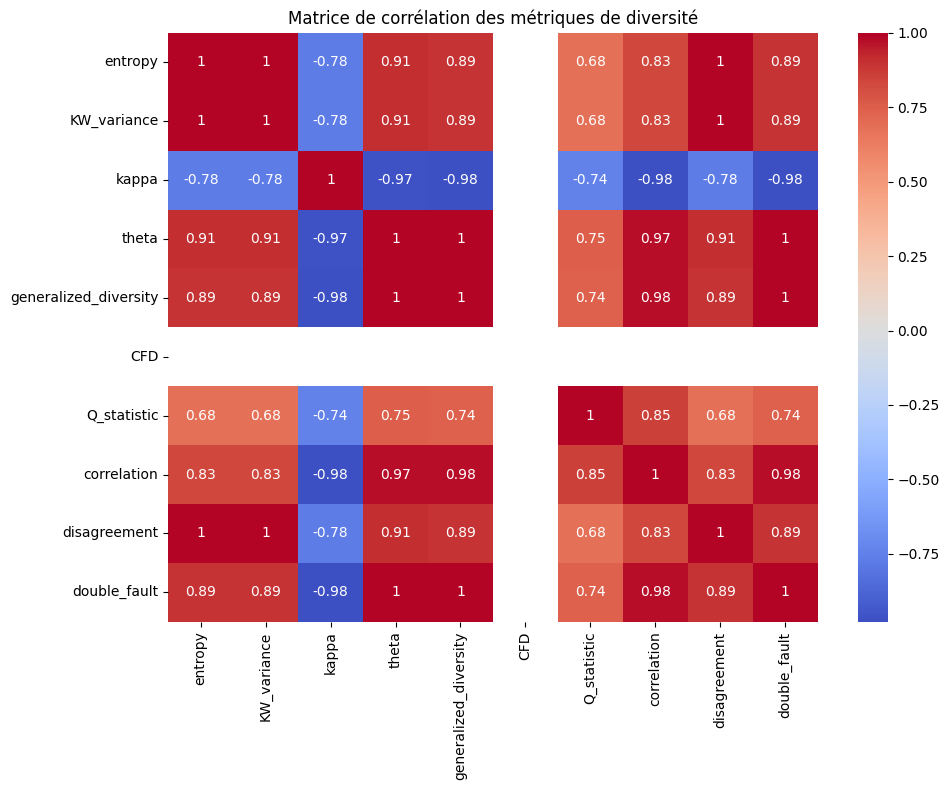

In [5]:
correlation_matrix= ut.calculate_diversity_metrics_correlation(models, X_test_scaled, y_test)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation des métriques de diversité")
plt.tight_layout()
plt.show()

In [8]:
def get_least_correlated_metrics(correlation_matrix, k):
    """
    Get the least correlated metric pairs from a correlation matrix.
    Parameters:
    correlation_matrix (pd.DataFrame): A DataFrame containing the correlation matrix.
    k (int): The number of least correlated metric pairs to return.
    Returns:
    pd.DataFrame: A DataFrame containing the least correlated metric pairs and their correlation values.
    """
    # Flatten the correlation matrix and get the absolute values
    corr_values = correlation_matrix.abs().unstack()
    
    # Remove self-correlations (diagonal elements)
    corr_values = corr_values[corr_values.index.get_level_values(0) != corr_values.index.get_level_values(1)]
    
    # Sort by correlation values in ascending order
    least_correlated = corr_values.sort_values().head(k)
    least_correlated = least_correlated.reset_index()
    least_correlated.columns = ['Metric_1', 'Metric_2', 'Correlation']
    # Return the metric pairs and their correlation values
    return least_correlated

In [8]:
correlation_matrix

,entropy,KW_variance,kappa,theta,generalized_diversity,CFD,Q_statistic,correlation,disagreement,double_fault
entropy,1.000000,1.000000,-0.776713,0.910335,0.894427,NaN,0.679807,0.834580,1.000000,0.894427
KW_variance,1.000000,1.000000,-0.776713,0.910335,0.894427,NaN,0.679807,0.834580,1.000000,0.894427
kappa,-0.776713,-0.776713,1.000000,-0.967552,-0.975907,NaN,-0.740153,-0.978268,-0.776713,-0.975907
theta,0.910335,0.910335,-0.967552,1.000000,0.999281,NaN,0.747693,0.973723,0.910335,0.999281
generalized_diversity,0.894427,0.894427,-0.975907,0.999281,1.000000,NaN,0.741292,0.975938,0.894427,1.000000
CFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q_statistic,0.679807,0.679807,-0.740153,0.747693,0.741292,NaN,1.000000,0.854604,0.679807,0.741292
correlation,0.834580,0.834580,-0.978268,0.973723,0.975938,NaN,0.854604,1.000000,0.834580,0.975938
disagreement,1.000000,1.000000,-0.776713,0.910335,0.894427,NaN,0.679807,0.834580,1.000000,0.894427
double_fault,0.894427,0.894427,-0.975907,0.999281,1.000000,NaN,0.741292,0.975938,0.894427,1.000000


In [9]:
ut.get_least_correlated_metrics(correlation_matrix, 4)

,Metric_1,Metric_2,Correlation
0,disagreement,Q_statistic,0.679807
1,entropy,Q_statistic,0.679807
2,Q_statistic,KW_variance,0.679807
3,kappa,Q_statistic,0.740153


### Testing the diversity metrics

In [4]:
# Calcul des 10 métriques pour l'ensemble des classifieurs
# 1. Pairwise metrics
metrics_pairwise = me.pairwise_metrics(oracle_matrix)
# 2. Non-pairwise metrics
metrics_non_pairwise = me.non_pairwise_metrics(oracle_matrix)

# Fusion
all_metrics = {**metrics_pairwise, **metrics_non_pairwise}

# Affichage
df_metrics = pd.DataFrame([all_metrics])
print(" Mesures de diversité pour l'ensemble des 4 modèles :")
display(df_metrics)

 Mesures de diversité pour l'ensemble des 4 modèles :


,Q_statistic,correlation,disagreement,double_fault,entropy,KW_variance,kappa,theta,generalized_diversity,CFD
0,0.882421,0.392217,0.094444,0.036111,0.147794,0.035417,-0.176471,0.040972,0.036111,0.0


### Finding the best k pairs of classifiers in diversity

For Q statistic only

In [5]:
diversity_values = me.calculate_q_statistic_for_models(models, X_test_scaled, y_test, 2)

print("Diversity Values:")
for key, value in diversity_values.items():
    print(f"{key}: {value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Diversity Values:
cnn_model vs decision_tree: 0.0
cnn_model vs kernel_svc: 0.0


For all pairwise metrics: top k pairs for each metric

In [11]:
print("Pairwise Metrics:")
pairwise_metrics = me.calculate_pairwise_metrics_for_models(models, X_test_scaled, y_test)
for metric, values in pairwise_metrics.items():
    print(f"{metric}:")
    for key, value in values.items():
        print(f"  {key}: {value[metric]}")

Pairwise Metrics:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Q_statistic:
  cnn_model vs decision_tree: 0.0
  cnn_model vs kernel_svc: 0.0
  cnn_model vs linear_svc: 0.0
  cnn_model vs random_forest: 0.0
  kernel_svc vs random_forest: 0.7999999999986667
  decision_tree vs linear_svc: 0.8518518518513261
  kernel_svc vs linear_svc: 0.8571428571420918
  decision_tree vs random_forest: 0.9082568807331117
  linear_svc vs random_forest: 0.9272727272718843
correlation:
  cnn_model vs decision_tree: 0.0
  cnn_model vs kernel_svc: 0.0
  cnn_model vs linear_svc: 0.0
  cnn_model vs random_forest: 0.0
  kernel_svc vs random_forest: 0.24525573579398632
  kernel_svc vs linear_svc: 0.3563483225498992
  decision_tree vs random_forest: 0.3930521575839001
  decision_tree vs linear_svc: 0.39803350093255985
  linear_svc vs random_forest: 0.4333408306443945
disagreement:
  cnn_model vs random_forest